# QuAllocation: A Quantum Organ Matching Algorithm

Welcome to QuAllocation!

We present a novel application of the MaxCut problem solved via the QAOA algorithm implemented through Qiskit. Specifically, given lists of organ donors and hopeful recipients, we match donor-patient pairs in a way that maximizes compatibility based on health metrics.

Below is the full backend of our application with detailed explanations and example runs.

## Setup

We begin by importing the necessary packages, including relevant Qiskit libraries and SciPy optimization.

In [106]:
# General imports
import numpy as np
import pandas as pd
import math

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize

Next we retrieve our list of donors and patients from the database. Unfortunately, we were unable to set up integration between this script and our functioning front-end. Thus we will use the below patients as an example, with the knowledge that given more time we would retrieve real-time data from the actual application.

Each person is a dictionary object with a type (donor or patient), name (for identification), and relevant attributes used in calculating their compatibility with other parties.

In [86]:
# Sample data
patients = [
    {'type': 'patient', 'name': 'Alice', 'blood_type': 'A', 'organ': 'heart', 'age': 20, 'location': (10, 20), 'health': 5},
    {'type': 'patient', 'name': 'Sarah', 'blood_type': 'B', 'organ': 'kidney', 'age': 70, 'location': (20, 40), 'health': 4},
    {'type': 'patient', 'name': 'Cindy', 'blood_type': 'AB', 'organ': 'heart', 'age': 60, 'location': (40, 30), 'health': 2}
]

donors = [
    {'type': 'donor', 'name': 'Lana', 'blood_type': 'O', 'organ': 'heart', 'age': 30, 'location': (30, 10), 'health': 2},
    {'type': 'donor', 'name': 'Megan', 'blood_type': 'A', 'organ': 'heart', 'age': 40, 'location': (10, 20), 'health': 4},
    {'type': 'donor', 'name': 'Maya', 'blood_type': 'B', 'organ': 'kidney', 'age': 50, 'location': (40, 50), 'health': 1}
]

BIG_WEIGHT = (len(donors)*len(patients))*10

## Computing Patient Compatibility

We compute the pairwise compatibility between patients and donors based on blood type, age, location, and health. It is a metric scaled between 0 and 1, with 1 being maximally compatible and 0 being not at all.

In [71]:
def blood_type(patient, donor):
    if patient['blood_type'] == donor['blood_type']:
        score = 1.0
    elif patient['blood_type'] == 'O' or donor['blood_type'] == 'O':
        score = 0.7
    elif (patient['blood_type'] == 'A' and donor['blood_type'] == 'B') or (patient['blood_type'] == 'B' and donor['blood_type'] == 'A'):
        score = 0.9
    elif (patient['blood_type'] in ('A', 'B') and donor['blood_type'] == 'AB') or (patient['blood_type'] == 'AB' and donor['blood_type'] in ('A', 'B')):
        score = 0.8
    else:
        score = 0
            
    return score

def organ(patient, donor):
    if patient['organ'] == donor['organ']:
        return 1
    else:
        return 0
    
def age(patient, donor):
    d_age = abs(patient['age'] - donor['age'])
    return max(0, 1.0 - 0.01 * d_age)

def health(patient, donor):
    return min(1.0, 0.1 * (patient['health'] + donor['health']))
    
def distance(patient, donor):
    loc1 = patient['location']
    loc2 = donor['location']
    
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

def get_compatibility(patient, donor):
    return min(blood_type(patient, donor), organ(patient, donor),
               blood_type(patient, donor) + organ(patient, donor) + age(patient, donor) + health(patient, donor) + distance(patient, donor))

## The Algorithm

The goal of this algorithm is to partition a bipartite graph (with donors as one group of nodes and patients as the other) into donor-patient pairs in a way that maximizes the total compatability between all pairs. To do this, we recursively partition the graph into two via the max-cut algorithm until only a pair remains.

### Graph Generation

Given a weighted, undirected graph, the max-cut algorithm looks for the best way to partition the graph into two sets of nodes such that the total weight of edges between nodes between the two sets is maximized.

In order to disincentivize our algorithm from creating a matching pair of two donors or two patients, we set create edges of weight
$$w_{ij} = 10MN$$
between every pair of people of the same type, where $M$ is the number of donors and $N$ is the number of patients. Recalling that all compatibility scores are normalized between 0 and 1, this guarantees that the algorithm will prioritize separating people of the same type above all other considerations (since the number of donor-patient connections is only $MN$).

We then recall the high compatibility was defined to be closer to 1. But since we wish to maximize the weights of cut edges and maintain the weights of preserved ones, we define our adjacency graph such that the weight between any patient and donor is
$$w_{ij} = 1 - C_{ij}$$
where $C$ is the compatibility score between donor $i$ and patient $j$.

In [99]:
def create_graph_array(donors, patients):
    
    num_donors = len(donors)
    num_patients = len(patients)

    # initializes adjacency graph, with donors first and patients second
    all_edges = np.zeros((num_donors + num_patients, num_donors + num_patients))

    # sets the compatibility between each donor-patient pair
    for donor in range(num_donors):
        for patient in range(num_patients):
            all_edges[donor][num_donors + patient] = 1-get_compatibility(donors[donor],patients[patient])

    # sets the weight between pairs of donors to be very high
    for donor1 in range(num_donors):
        for donor2 in range(donor1+1,num_donors):
            all_edges[donor1][donor2] = BIG_WEIGHT

    # sets the weight between pairs of patients to be very high
    for patient1 in range(num_patients):
        for patient2 in range(patient1+1,num_patients):
            all_edges[num_donors + patient1][num_donors + patient2] = BIG_WEIGHT
    
    return all_edges

### Translation into Cost Function

Next, we translate the adjacency graph into a Hamiltonian cost function for the QAOA algorithm (see appendix) to optimize.

We wish to incentivize two nodes to be in different partitions when the edge weight between them is high. We can use the following matrix to achieve this:
$$\begin{pmatrix}w_{ij} &0 &0 &0 \\ 0 &-w_{ij} &0&0 \\ 0&0 &-w_{ij} &0 \\ 0&0&0 &w_{ij}\end{pmatrix} = w_{ij}Z\otimes Z$$
Thus for each pair of people, we can prepare the Hamiltonian
$$H_{ij} = w_{ij}Z_iZ_j$$
where we tensor the identity $I$ with itself $M + N$ times, except for in the $i$ and $j$ positions where we replace with a $Z$.

Here we note that the matrices we have defined a very sparse and also only consist of $Z$, we can simply add them to achieve our final Hamiltonian
$$H = \sum_{i=1}^M \sum_{j=1}^M H_{ij}$$
This is the function we will now optimize using QAOA.

In [98]:
# given an adjacency graph, generates the individual Hamiltonian matrices
# that will be used as input for the Qiskit QAOA implementation
def graph_to_list(graph):
    
    num_people = graph.shape[0]
    matrix_list = []
    
    for p1 in range(num_people):
        for p2 in range(p1+1, num_people):
            # creates the Hamiltonian tensor expression
            matrix = "I"*p1 + "Z" + "I"*(p2-p1-1) + "Z" + "I"*(num_people - p2-1)
            weight = graph[p1][p2]
            matrix_list.append((matrix, weight))
    return matrix_list

### Finding the Optimal Parition

To find the optimal partition, we utilize Qiskit's implementation of the Quantum approximate optimization algorithm (QAOA). This algorithm works by beginning in the ground state and slowly evolving our Hamiltonian such that each small time step may be approximated by smaller, independent operators rather than one very large, computationally expensive one.

The output of this optimization function is a list of all possible partitions in the form of a bitstring. Each '0' at position $k$ in the string means that the person at position $k$ in the adjacency graph belongs to one group, and the rest labeled with '1' belong to the other group of the partition. The optimal partition is chosen by selecting the configuration with the highest binary probability.

The next few cells contain helper functions for running the partition algorithm, as well as the main function.

Due to excessively long wait times, we were unable to run our algorithm on the actual quantum hardware. However, the code to do so would be exactly the same as below, except switching the backend target.


In [102]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend = service.get_backend("ibmq_qasm_simulator")

qiskit_runtime_service.__init__:INFO:2024-02-04 08:01:41,586: Default instance: ibm-q/open/main


In [103]:
# returns the estimate of energy cost from estimator, based on the cost function
def cost_func(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [104]:
# function for identifying the optimal configuration from simulation results
# returns an array of length M + N, splitting the group into two groups based on index and labeled 0 or 1
def process_results(samp_dist):
    
    probs = samp_dist.binary_probabilities() # gets probabilities
    
    best_prob = 0
    best_config = next(iter(process_results.values()))
    # iterates through to find the highest probability
    for config in probs.keys():
        if probs[config] > best_prob:
            best_prob = probs[config]
            best_config = config
    
    # splits into array of integers for easier parsing
    split_config = [*config]
    for i,v in enumerate(split_config):
        split_config[i] = int(v)
    return split_config

In [75]:
def generate_cut(graph):
   
    # generates the actual Hamiltonian of interest from the adjacency matrix of the graph
    matrix_list = graph_to_list(graph)
    hamiltonian = SparsePauliOp.from_list(matrix_list)
    
    # sets up the optimization
    ansatz = QAOAAnsatz(hamiltonian, reps=2)    
    options = Options()
    options.transpilation.skip_transpilation = True
    options.execution.shots = 10000

    session = Session(backend=backend)
    estimator = Estimator(session=session, options={"shots": int(1e4)})
    sampler = Sampler(session=session, options={"shots": int(1e4)})

    # sets an initial random state
    x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
    
    # optimization step
    res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")
    
    # Assign solution parameters to ansatz
    qc = ansatz.assign_parameters(res.x)
    # Add measurements to our circuit
    qc.measure_all()
    
    # Sample ansatz at optimal parameters
    samp_dist = sampler.run(qc).result().quasi_dists[0]
    # Close the session since we are now done with it
    session.close()
    
    return process_results(samp_dist) # from the simulation results, finds the most likely optimal partition

### Recursive Step

The above code allows us to find a partition that maximizes the weight of cut edges between two groups. However, our goal is to partition our graph into many groups, such that each group is simply a patient-donor pair.

To achieve this, we recursively call our generate_cut function on separate halves of the graph until we hit a graph of size less than 2. Since we designed our weights to be very high between people of the same type, we know that each cut will partition the graph into roughly equal subgraphs. Thus this recursive method is efficient in reducing the search space by 1/2 every iteration.

In [76]:
def max_cut_people(graph, people):
    
    # print the current iteration for easier tracing
    print("\n****** RUNNING MAX CUT ON ******")
    print(people)
    
    # base cases: do not keep iterating
    if len(people) == 2:
        return [people] # if there are two people, return them as a matched pair
    if len(people) == 1:
        return [[people[0], -1]] # if there is one person, they do not get a match :(
    if len(people) == 0:
        return [] # we ignore this if there are no people to consider
    
    # in the non-base case, we partition the graph into two by our described max-cut algorithm
    partition = generate_cut(graph)
    
    # sort the people into two groups based on the partition, and reconstruct the adjacency graphs
    people_ids1 = []
    people_ids2 = []
    for i,p in enumerate(partition):
        if p==0:
            people_ids1.append(i)
        else:
            people_ids2.append(i)
    graph1 = np.zeros((len(people_ids1),len(people_ids1)))
    graph2 = np.zeros((len(people_ids2),len(people_ids2)))
    people1 = []
    people2 = []
    for i,p in enumerate(people_ids1):
        people1.append(people[p])
        for j in range(i+1,len(people_ids1)):
            graph1[i][j] = graph[p][people_ids1[j]]
    for i,p in enumerate(people_ids2):
        people2.append(people[p])
        for j in range(i+1,len(people_ids2)):
            graph2[i][j] = graph[p][people_ids2[j]]
            
    # return the next recursive iteration
    return max_cut_people(graph1, people1) + max_cut_people(graph2, people2)

## Results and Example

Our recursive function ends and returns a list of matched pairs. The final step is to print/present them in a clean format, remembering to invert the compatibility score since it was inverted before for the graph.

In [92]:
def print_results(og_people, og_graph, results):
    total_compatibility = 0
    for pair in results:
        good_pair = True
        p1 = ""
        p2 = ""
        comp = 0
        if pair[0] == -1:
            p1 = "NO PARTNER"
            good_pair = False
        else:
            p1 = pair[0]["name"]
            # p1 = pair[0]
        if pair[1] == -1:
            p2 = "NO PARTNER"
            good_pair = False
        else:
            p2 = pair[1]["name"]
            # p2 = pair[1]
        if good_pair:
            comp = 1-og_graph[og_people.index(pair[0])][og_people.index(pair[1])]
        total_compatibility += comp
        print(p1 + "\t matched with \t" + p2 + "\t with compatability \t" + str(comp))
    print("Average compatibility: " +  str(total_compatibility/len(results)))

### Example with Figures

We now provide an example of this algorithm in progress on the six sample people objects given in the beginning of this document. To begin, we compute the pairwise compatibility between patients and donors. The following graph represents the result of such computation:

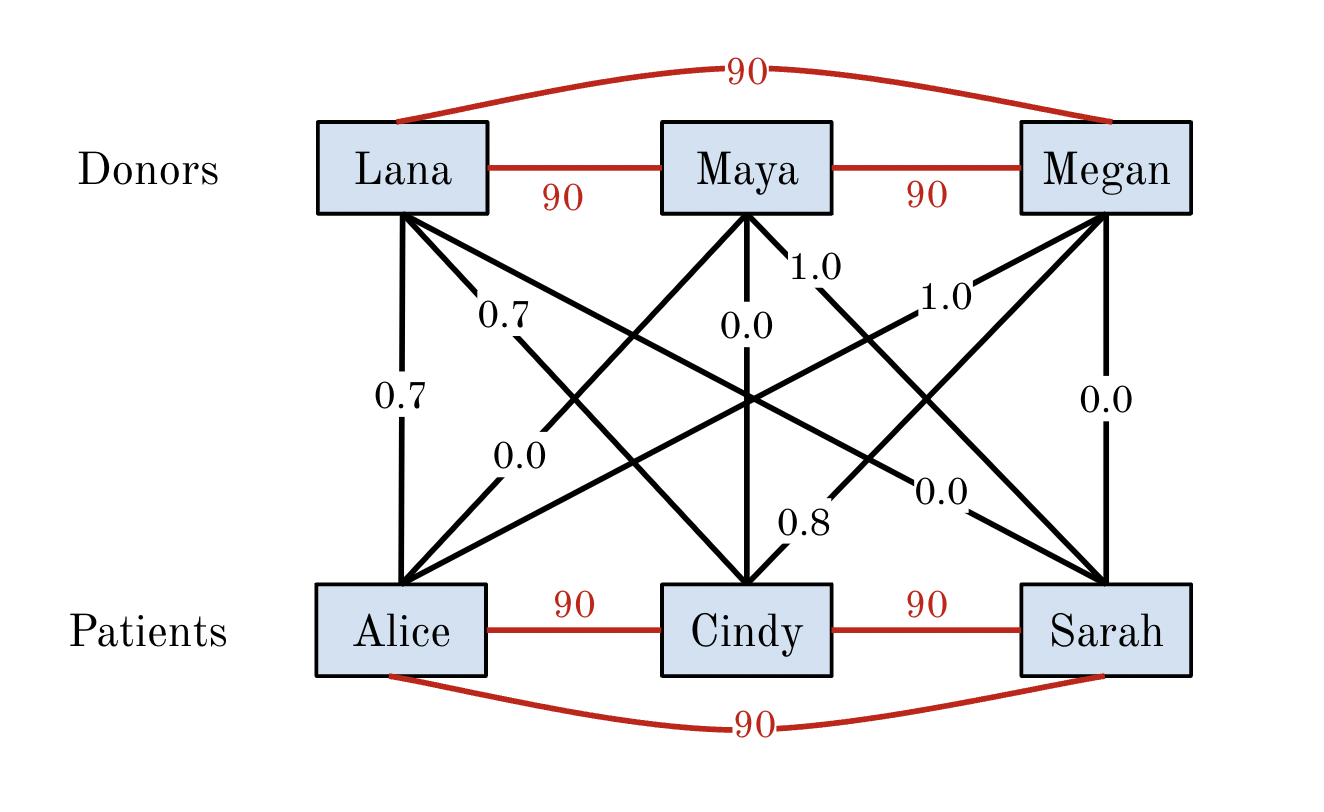

Next we convert this into an adjacency graph:

In [110]:
og_graph = create_graph_array(donors,patients)
og_graph

array([[ 0. , 90. , 90. ,  0.3,  1. ,  0.3],
       [ 0. ,  0. , 90. ,  0. ,  1. ,  0.2],
       [ 0. ,  0. ,  0. ,  1. ,  0. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. , 90. , 90. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. , 90. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

Now we can run the recursive optimization function, which will iterate through the following steps (based on real data from a run)

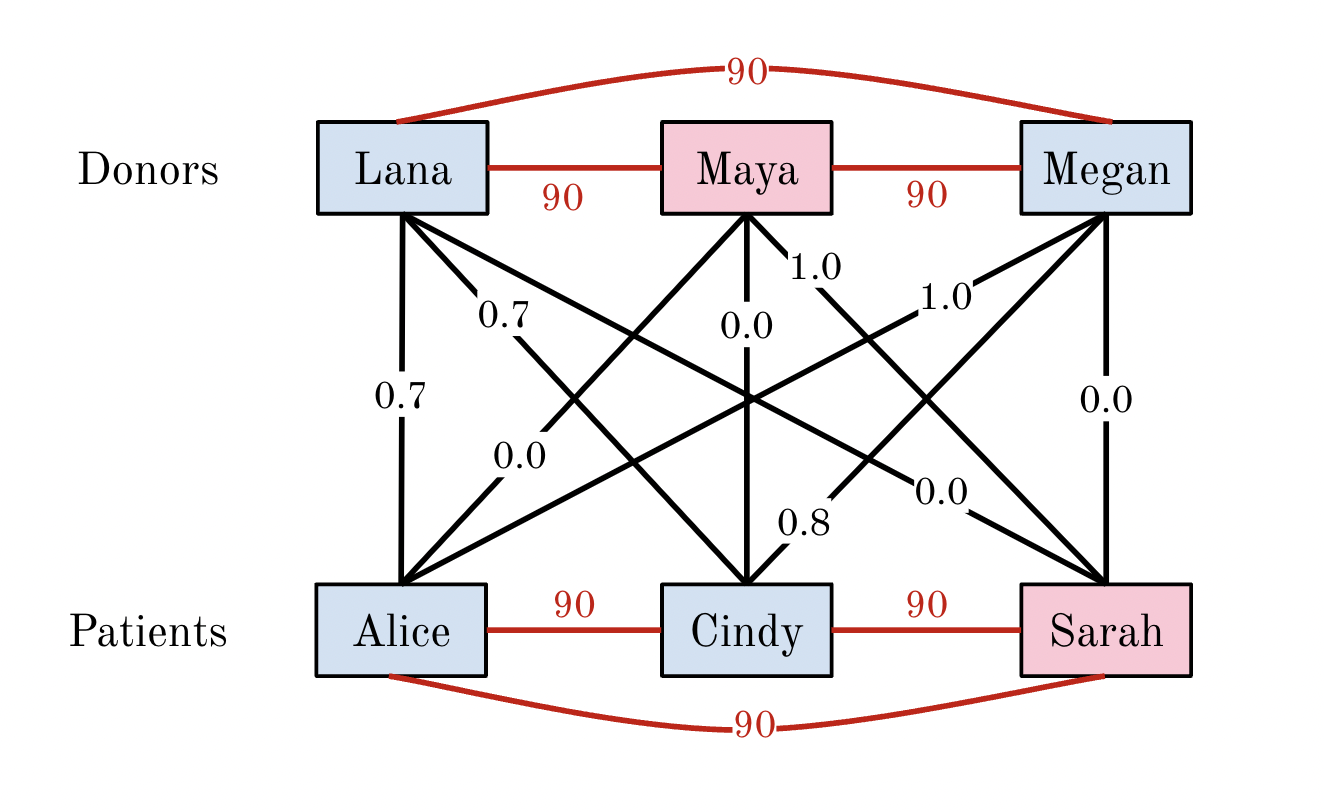

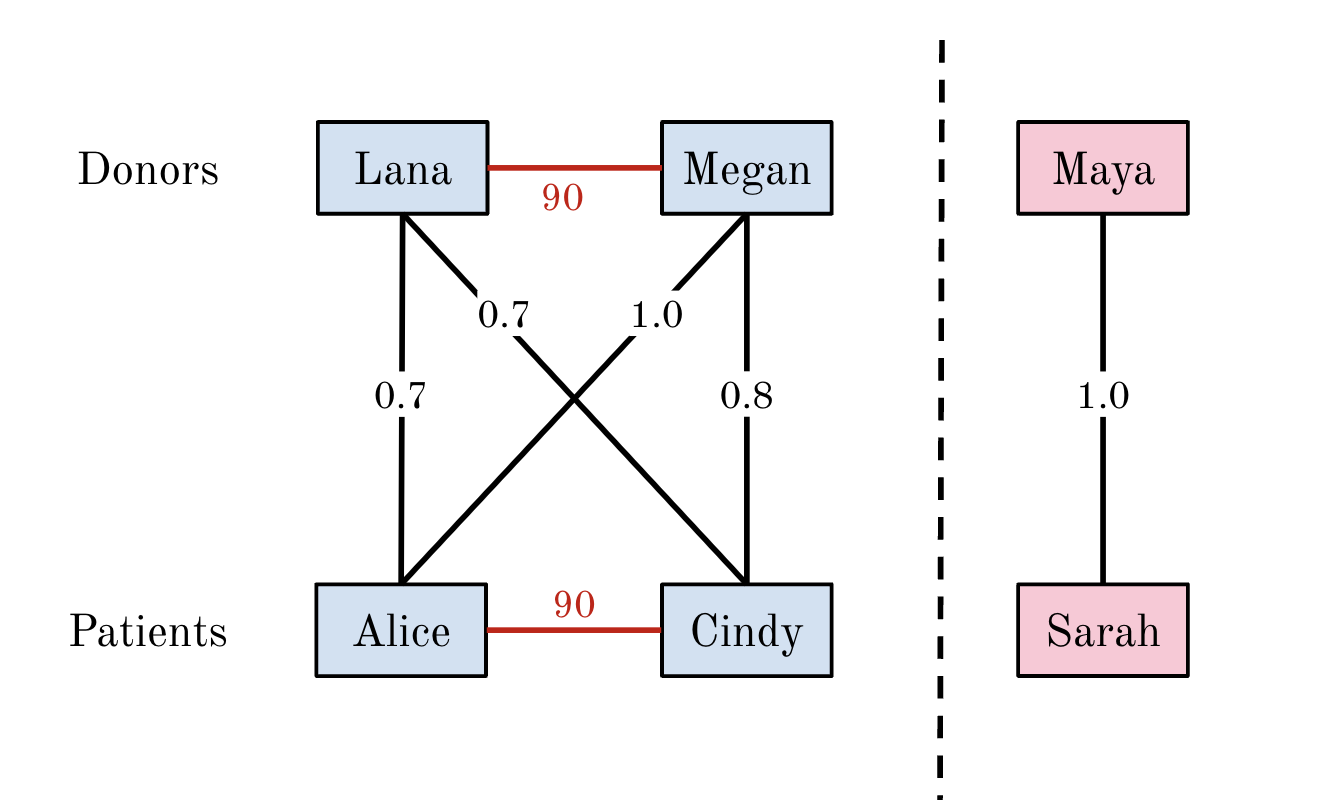

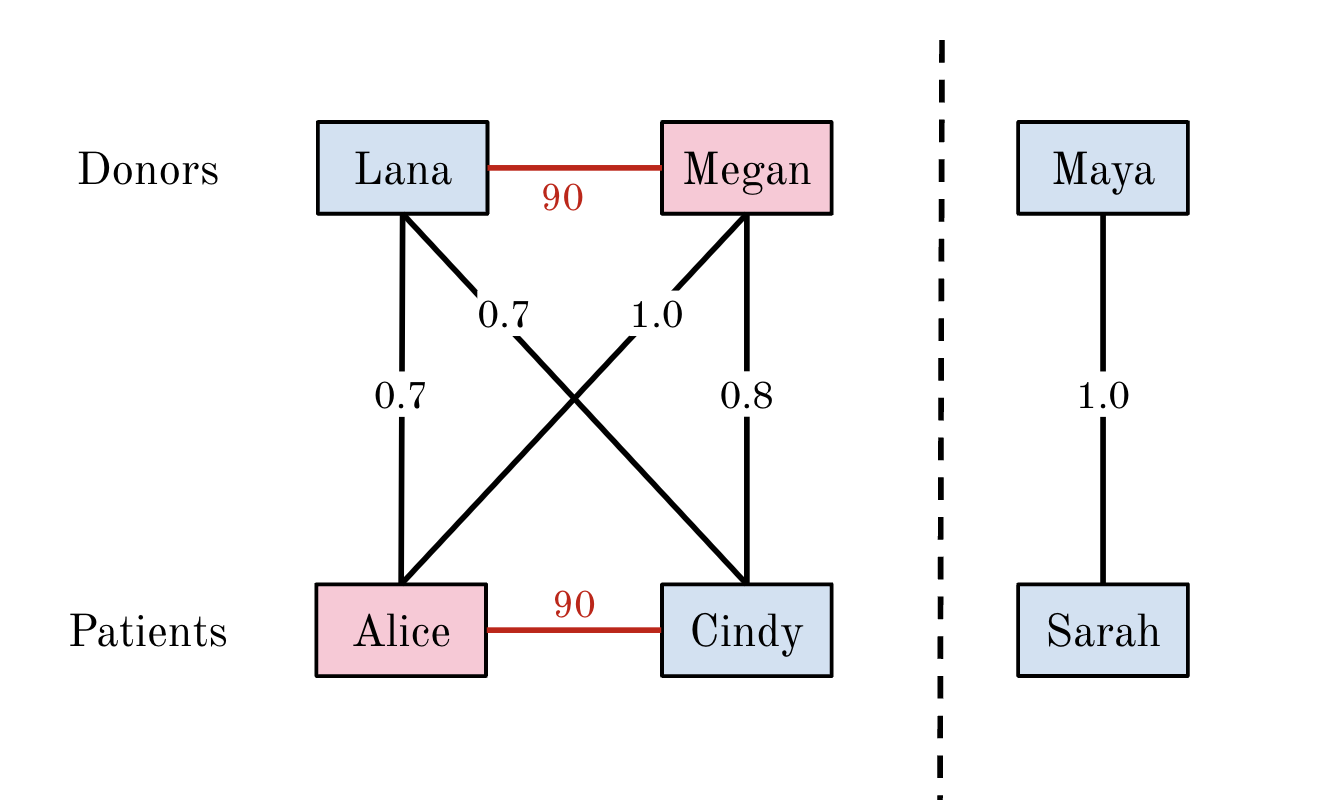

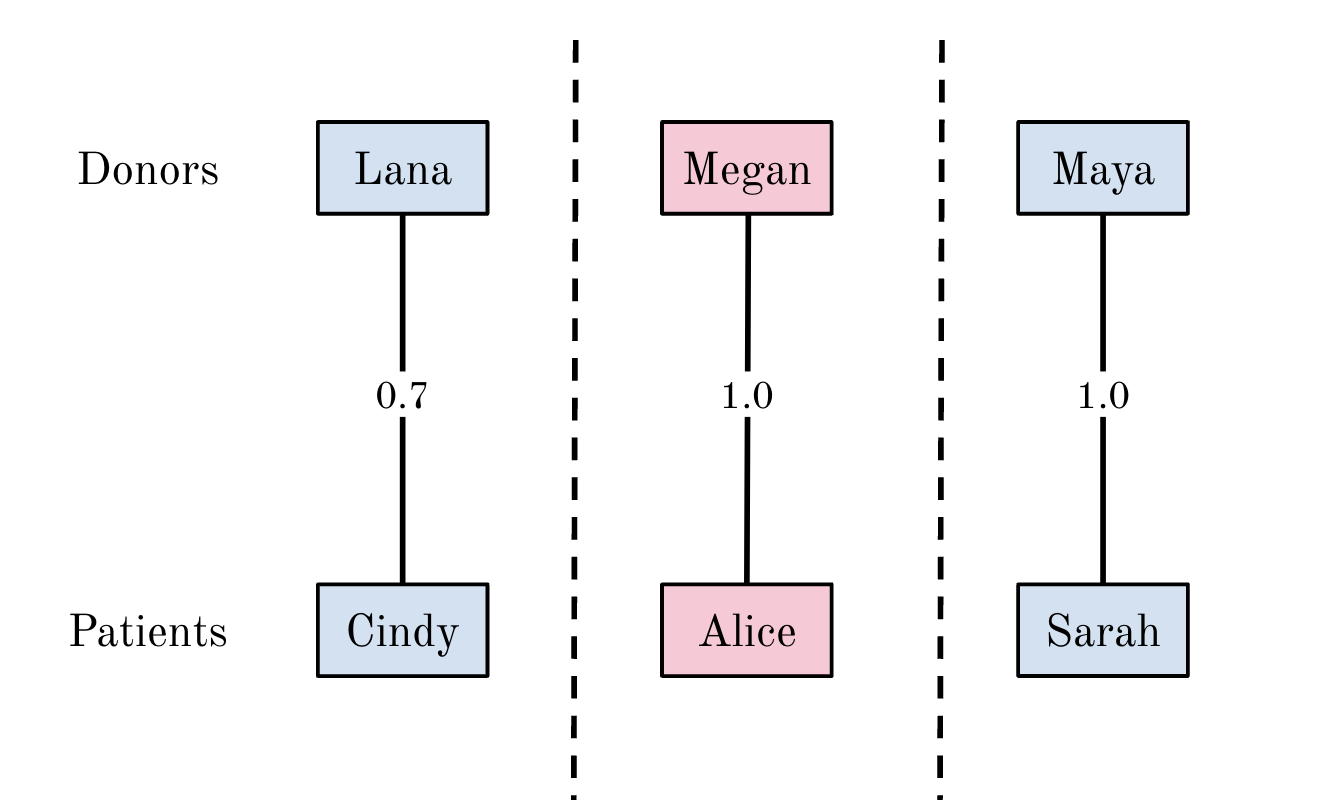

In [ ]:
results = max_cut_people(og_graph, donors+patients)
print_results(donors+patients, og_graph, results)

And there we have it! A successful implementation of our modified max-cut algorithm for organ matching, implemented on IBM's quantum hardware :)

## Strengths and Limitations

There are several strenghts to our algorithm, including:

1. Simplicity: our model uses the max-cut algorithm on QAOA, which is very well-documented and explainable. Similarly, the recursive nature of the method is also easy to trace, and much easier to implement than using a single, ultra-complicated cost function.

2. Guarantees donor-patient matches: by design, the algorithm will avoid creating a connection between any two people of the same type, even at the cost of failing to create any compatible connections. This solves one of our biggest problems we encountered before coming up with this algorithm: how to create an optimization problem that avoids completely nonsensical graphs.

3. Flexibility: the model allows for different numbers of donors and patients and will exhibit roughly the same behavior regardless. This reflects many real-life scenarios where there may be a surplus of patients in comparision donors, so it is increasingly crucial to create the most compatible/helpful matches to optimize life-saving.

4. Applicability: although we applied our algorithm to organ donor-patient matching, our matchmaking algorithm can be applied to any other similar scenario in which we try to create pairs to maximize some weighing function. These could include romantic partnership, internship pairing, traffic flow, etc.



Because of the strict time limitation and despite our best efforts, there are several limitations to this algorithm. Some of these include:

1. Inaccuracy: This algorithm does not necessarily identify the most globally optimal configuration. Because, after each partition, nodes may only pair with other nodes within their partition, the most optimal configuration for certain pairs may be blocked.

2. Extra mismatches: Again because of the partitioning nature, if one side of a partition has an odd number of nodes, there is at least one person guaranteed not to have a match. If this happens on both sides with people of different types, this is obviously inefficient. 